## 本題

In [134]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [135]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]

In [136]:
train_df.sample(5)

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
3568,BIG RIVER RESOURCES BOYCEVILLE LLC,45.045391,-91.976466,N10185 370TH ST,BOYCEVILLE,WI,54725,55033.0,325193,NaN,"Other,Suppliers of CO2,Waste",38651.033561,32188.012435,35813.452731,35439.068727,48016.584276,27328.443706,86004.778937,53157.748140,55228.543261
2303,JIREH SEMICONDUCTOR INC,45.547740,-122.927950,3131 NE BROOKWOOD PKWY,HILLSBORO,OR,971245303,41067.0,334413,NaN,Other,20272.088967,18495.599869,19007.327564,21973.899203,54536.971483,7248.501477,71076.667106,38654.958472,52236.338219
4416,QUAIL RUN ENERGY CENTER,31.815832,-102.395915,2950 E I 20,ODESSA,TX,79766-8837,48135.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,301063.536108,720635.052052,860205.653243,406699.888649,597965.388436
2883,TARGA SILVER OAK GAS PLANT,NaN,NaN,8402 COUNTY ROAD 107,TULETA,TX,78162,48025.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35578.461433,39348.931145
3542,ALLEGHENY ENERGY UNIT 1 & 2,40.544700,-79.767800,198 BUTLER ST EXTENSION,SPRINGDALE,PA,15144-0146,42003.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,91287.117090,82223.158059,470391.925437,80337.982739,32641.639814


In [137]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns) | set(lat_lon_columns) | set(target_columns))))

## 前処理

### City

In [138]:
# # target encoding for city column
# City_median = train_df.groupby('City').GHG_Direct_Emissions_14_in_metric_tons.median()
# train_df['City_median'] = train_df['City'].map(City_median)
# test_df['City_median'] = test_df['City'].map(City_median)

# # if city is not present in test data then fill it with global median
# test_df['City_median'] = test_df['City_median'].fillna(train_df.GHG_Direct_Emissions_14_in_metric_tons.median())
# numerical_columns.append('City_median')

In [139]:
def Holdout_target_encoding(train, test, target, categorical_columns, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=13)
    for col in tqdm(categorical_columns):
        train[col + '_enc'] = np.nan
        for train_index, valid_index in kf.split(train):
            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            means = X_valid[col].map(X_train.groupby(col)[target].mean())
            train.loc[valid_index, col + '_enc'] = means
        test[col + '_enc'] = test[col].map(train.groupby(col)[target].mean())
        test[col + '_enc'].fillna(train[target].mean(), inplace=True)
    return train, test
    
train_df, test_df = Holdout_target_encoding(train_df, test_df, 'GHG_Direct_Emissions_14_in_metric_tons', categorical_columns)
numerical_columns += [col + '_enc' for col in categorical_columns]

100%|██████████| 6/6 [00:00<00:00, 18.26it/s]


In [140]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique  = set(test_df[colname].unique())
    intersection = test_unique & train_unique
    return len(intersection)/test_df.shape[0]

In [141]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - IndustryType has 1.5151515151515151% values in train data
column - ZIP has 21.251993620414673% values in train data
column - LocationAddress has 1.036682615629984% values in train data
column - City has 34.05103668261563% values in train data
column - State has 2.15311004784689% values in train data
column - FacilityName has 3.5486443381180224% values in train data


In [142]:
def create_features1(df):

    
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # Year-over-year growth rate
    df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [143]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                     'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']


train_df      = create_features2(train_df)
test_df       = create_features2(test_df)
new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 + new_features2

In [144]:
train = train_df[numerical_columns].values 
test  = test_df[numerical_columns].values 
target = train_df[target_columns].values

## Optuna

In [ ]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1)
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_params = study.best_params
optuna_params['random_state'] = 13
optuna_params['verbose'] = -1

    

[I 2024-11-05 11:28:07,518] A new study created in memory with name: no-name-22d4fe98-2c8d-4211-a1d3-6ccb3bed53fc
[I 2024-11-05 11:28:16,756] Trial 0 finished with value: 0.7946982363974247 and parameters: {'n_estimators': 283, 'learning_rate': 0.06958379309002978, 'num_leaves': 126, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.7754824628868928, 'colsample_bytree': 0.6917159544791729, 'reg_alpha': 0.013069083794483741, 'reg_lambda': 0.005084521810783995}. Best is trial 0 with value: 0.7946982363974247.
[I 2024-11-05 11:28:49,333] Trial 1 finished with value: 0.944470981254589 and parameters: {'n_estimators': 995, 'learning_rate': 0.0007204540945468384, 'num_leaves': 189, 'max_depth': 11, 'min_child_samples': 32, 'subsample': 0.8687573459594264, 'colsample_bytree': 0.5623949342189509, 'reg_alpha': 0.04102408429224301, 'reg_lambda': 0.1850372349736732}. Best is trial 0 with value: 0.7946982363974247.
[I 2024-11-05 11:29:03,624] Trial 2 finished with value: 0.8047922506445089 

LGBMRegressor(colsample_bytree=0.8358705659246646,
              learning_rate=0.0068865957878983895, max_depth=7,
              min_child_samples=92, n_estimators=809, num_leaves=135,
              random_state=13, reg_alpha=4.975602401979477,
              reg_lambda=1.0396773387217721, subsample=0.6590210406209819,
              verbose=-1)

In [153]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid             = train[train_index], train[valid_index]
        y_train, y_valid             = target[train_index], target[valid_index]

        params                       = optuna_params
        model1                       = LGBMRegressor(**params)

        params                       = { 'random_state':13,}
        model2                       = HistGradientBoostingRegressor(**params)

        _                             = model1.fit(X_train,np.log1p(y_train))        
        valid_preds1                  = np.expm1(model1.predict(X_valid))
        rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        _                             = model2.fit(X_train,np.log1p(y_train))        
        valid_preds2                  = np.expm1(model2.predict(X_valid))
        rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")


        if rmsle1>=rmsle2:
            valid_preds = valid_preds2.copy()
            test_preds  = model2.predict(test)
        else:
            valid_preds = valid_preds1.copy()
            test_preds  = model1.predict(test)
        
    
        oof_predictions[valid_index]  = valid_preds
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,np.expm1(test_predictions), model1

In [154]:
oof_predictions,test_predictions, model = get_models_trained(train,test,target,15)

Fold 1 RMSLE for model1 = 0.7135153314702484
Fold 1 RMSLE for model2 = 0.7235658159622861
---------------

Fold 2 RMSLE for model1 = 0.6797086585019646
Fold 2 RMSLE for model2 = 0.6905216702330347
---------------

Fold 3 RMSLE for model1 = 0.8127144015242468
Fold 3 RMSLE for model2 = 0.8143650488712009
---------------

Fold 4 RMSLE for model1 = 0.7248608410213051
Fold 4 RMSLE for model2 = 0.7447353421892912
---------------

Fold 5 RMSLE for model1 = 0.8357023069188038
Fold 5 RMSLE for model2 = 0.8556470695837832
---------------

Fold 6 RMSLE for model1 = 0.7942602106175992
Fold 6 RMSLE for model2 = 0.8154624006363059
---------------

Fold 7 RMSLE for model1 = 0.7708914697449248
Fold 7 RMSLE for model2 = 0.7766237637296667
---------------

Fold 8 RMSLE for model1 = 0.6577563824935485
Fold 8 RMSLE for model2 = 0.6892176152674844
---------------

Fold 9 RMSLE for model1 = 0.7584611223358427
Fold 9 RMSLE for model2 = 0.7706409755432208
---------------

Fold 10 RMSLE for model1 = 0.78632233

## 後分析

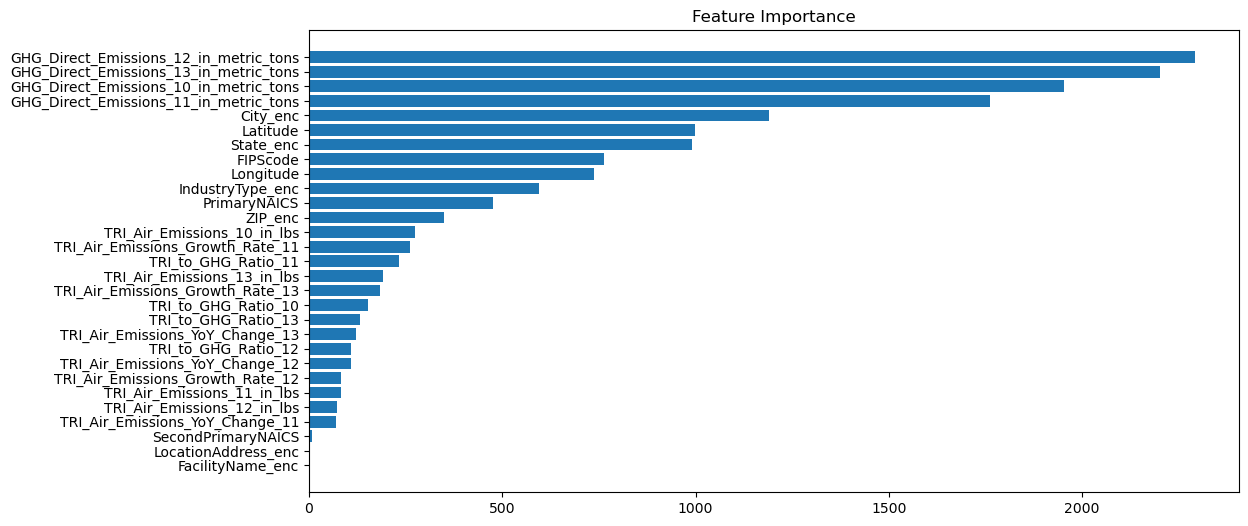

In [155]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, numerical_columns)

In [156]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )